In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import linalg
from collections.abc import Iterable

## PharmacoKinetics

In [2]:
def central_dydt(current_state, params):
    dC_dt = (params["k_dose"]*current_state["dose"]
            + sum(params["Q_perif"]*(current_state["peripheral"]/params["Vol_perif"]))
            - sum(params["Q_perif"]*(current_state["central"]/params["Vol_C"]))
            - params["Cl"]*(current_state["central"]/params["Vol_C"]))
    return dC_dt

def perif_dydt(current_state, params):
    dP_dt = (params["Q_perif"]*(current_state["central"]/params["Vol_C"])
            - params["Q_perif"]*(current_state["peripheral"]/params["Vol_perif"]))
    return dP_dt

def dose_iv(t):
    return 0
    
def PK_iv_dydt(y, t, param_values, comp=2):
    if comp==1:
        current_state= {'central': y, "peripheral":np.asarray([])}
        current_state["dose"] = dose_iv(t)
        params = {"k_dose" : 1, "Vol_C" : param_values[0], "Cl" : param_values[1], "Vol_perif" : np.asarray([]), "Q_perif" : np.asarray([])}
        
        dy_dt = central_dydt(current_state, params)
        
    else:
        current_state= {'central': y[0], "peripheral":np.asarray(y[1:])}
        current_state["dose"] = dose_iv(t)
        params= {"k_dose" : 1, "Vol_C" : param_values[0], "Cl" : param_values[1], "Vol_perif" : np.asarray(param_values[2]), "Q_perif" : np.asarray(param_values[3])}
        
        dC_dt = central_dydt(current_state, params)
        dP_dt = perif_dydt(current_state, params)
        dy_dt = np.insert(dP_dt, [0], [dC_dt])
    
    return dy_dt

def PK_iv_result(dose, num_comp, parameter, times):
    if len(parameter) != 2*num_comp:
        raise ValueError(
                'Number of Parameters does not match the number of Compartments')
    Vol_C = parameter[0]
    Cl = parameter[1]
    Vol_perif = parameter[2:num_comp+1]
    Q_perif = parameter[num_comp+1:]
    y_0 = [dose] +[0]*(num_comp-1)
    results_amt = integrate.odeint(PK_iv_dydt, y_0, times, args=((Vol_C, Cl, Vol_perif, Q_perif), num_comp))
    results_conc = results_amt/np.insert(Vol_perif, [0], Vol_C)
    return results_conc

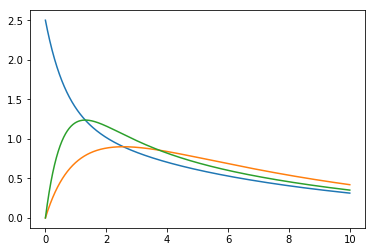

In [3]:
if __name__ == '__main__':
    # Params:
    k_dose = 1
    k_perif = 0.5
    Vol_perif = 1
    Cl = 0.5
    Vol_C = 2

    dose = 5
    time_span = 10
    times = np.linspace(0,time_span,1000)
    plt.plot(times, PK_iv_result(dose, 3, [Vol_C, Cl, Vol_perif, Vol_perif*0.5, k_perif, k_perif+0.1], times)[:,:])
    plt.show

### Analytical Solution

This is not neccessary for inferring the PK parameters but it will make calculating PD easier.

t= 1 ; C_t = (0.92749164073+0j)
0.463745820365
t= [ -2.00000000e+00  -1.49494949e+00  -9.89898990e-01  -4.84848485e-01
   2.02020202e-02   5.25252525e-01   1.03030303e+00   1.53535354e+00
   2.04040404e+00   2.54545455e+00   3.05050505e+00   3.55555556e+00
   4.06060606e+00   4.56565657e+00   5.07070707e+00   5.57575758e+00
   6.08080808e+00   6.58585859e+00   7.09090909e+00   7.59595960e+00
   8.10101010e+00   8.60606061e+00   9.11111111e+00   9.61616162e+00
   1.01212121e+01   1.06262626e+01   1.11313131e+01   1.16363636e+01
   1.21414141e+01   1.26464646e+01   1.31515152e+01   1.36565657e+01
   1.41616162e+01   1.46666667e+01   1.51717172e+01   1.56767677e+01
   1.61818182e+01   1.66868687e+01   1.71919192e+01   1.76969697e+01
   1.82020202e+01   1.87070707e+01   1.92121212e+01   1.97171717e+01
   2.02222222e+01   2.07272727e+01   2.12323232e+01   2.17373737e+01
   2.22424242e+01   2.27474747e+01   2.32525253e+01   2.37575758e+01
   2.42626263e+01   2.47676768e+01   2.52727273e+01  

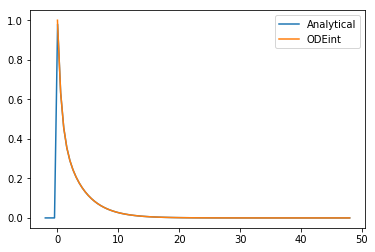

In [4]:
def solve_2_comp(dose, params, t):
    if isinstance(t, Iterable)==False and t<0:
        print("t =", t, "; C_t = 0")
        return 0
    else:
        Vol_C = params[0]
        Cl = params[1]
        Vol_perif = params[2]
        Q = params[3]

        A = np.asarray([[-(Cl+Q)/Vol_C, Q/Vol_perif], [Q/Vol_C, -Q/Vol_perif]])
        x_0 = np.array([dose, 0])
        eigvalues, eigvectors = linalg.eig(A)

        if eigvalues[0]==eigvalues[1]:
            # print('Identical Eigenvalues')
            l = eigvalues[0]
            nu = eigvectors[0]
            rho = linalg.solve(A-l*np.identity(2), nu)
            c = linalg.solve([[nu[0], rho[0]],[nu[1], rho[1]]], x_0)
            C_t = c[0]*np.exp(l*t)*nu[0] + c[1]*(t*np.exp(l*t)*nu[0] +np.exp(l*t)*rho[0])
            print("t=", t, "; C_t =", C_t)
            
        elif eigvalues[0].imag == 0:
            # print('Real, Distinct Eigenvalues')
            l1, l2 = eigvalues
            nu1, nu2 = eigvectors
            c = linalg.solve([[nu1[0], nu2[0]],[nu1[1], nu2[1]]], x_0)
            C_t = c[0]*np.exp(l1*t)*nu1[0] + c[1]*np.exp(l2*t)*nu2[0]
            print("t=", t, "; C_t =", C_t)
            
        else:
            # print('Imaginary Eigenvalues')
            b = eigvalues[0].real
            a = eigvalues[0].imag
            nu = eigvectors[0]
            def u_v(time):
                ut_plus_ivt = np.exp(b*time)*(np.cos(a*time) + j*np.sin(b*time))*nu
                return (ut_plus_ivt.real, ut_plus_ivt.imag)
            
            u_0 = u_v(0)[0]
            v_0 = u_v(0)[1]
            c = linalg.solve([[u_0[0], v_0[0]],[u_0[1], v_0[1]]], x_0)
            C_t = c[0]*u_v(t)[0] + c[1]*u_v(t)[1]
            print("t=", t, "; C_t =", C_t)
        
        if isinstance(t, Iterable):
            times_before_dose = np.count_nonzero(t < 0)
            C_t[:times_before_dose] = 0
        return C_t.real/Vol_C

    
if __name__ == '__main__':
    
    Q_perif = 1
    Vol_perif = 1
    Cl = 1
    Vol_C = 2
    dose = 2
    print(solve_2_comp(2, [Vol_C, Cl, Vol_perif, Q_perif], 1))
    
    times = np.linspace(-2, 48, 100)
    times_before_dose = np.count_nonzero(times < 0)
    int_times = np.concatenate((np.zeros(1), times[times_before_dose:]))
    
    plt.plot(times, solve_2_comp(dose, [Vol_C, Cl, Vol_perif, Q_perif], times), label='Analytical')
    plt.plot(int_times, PK_iv_result(dose, 2, [Vol_C, Cl, Vol_perif, Q_perif], int_times)[:,0], label = 'ODEint')
    plt.legend()
    plt.show

## Pharmacodynamics

In [5]:
def proliferation_dydt(current_state, PD_Params):
    dProl_dt = (PD_Params["k_prol"]*current_state["Prol"]
                *(1-E_Drug(current_state["Conc"], PD_Params["slope"]))
                *np.power((PD_Params["Circ_0"]/current_state["Circ"]), PD_Params["gamma"])
                - PD_Params["k_tr"]*current_state["Prol"])
    return dProl_dt
    
def transit_dydt(current_state, PD_Params):
    dT1_dt = PD_Params["k_tr"]*current_state["Prol"] - PD_Params["k_tr"]*current_state["T1"]
    dT2_dt = PD_Params["k_tr"]*current_state["T1"] - PD_Params["k_tr"]*current_state["T2"]
    dT3_dt = PD_Params["k_tr"]*current_state["T2"] - PD_Params["k_tr"]*current_state["T3"]
    return (dT1_dt, dT2_dt, dT3_dt)

def circulation_dydt(current_state, PD_Params):
    dCirc_dt = PD_Params["k_tr"]*current_state["T3"] - PD_Params["k_circ"]*current_state["Circ"]
    return dCirc_dt

def PD(y, t, PD_params, PK_params, num_comp, dose):
    variables = ["Prol", "T1", "T2", "T3", "Circ"]
    current_state = dict(zip(variables, y))
    current_state["Conc"] = drug_conc(t, PK_params, num_comp, dose)
    
    parameter_names = ["k_tr", "k_prol", "k_circ", "Circ_0", "gamma", "slope"]
    PD_params = dict(zip(parameter_names, PD_params))
    
    dProl_dt = proliferation_dydt(current_state, PD_params)
    dCirc_dt = circulation_dydt(current_state, PD_params)
    dT1_dt, dT2_dt, dT3_dt = transit_dydt(current_state, PD_params)
    return [dProl_dt, dT1_dt, dT2_dt, dT3_dt, dCirc_dt]

def PD_result(dose, num_comp, parameter, times):
    if len(parameter) != 2*num_comp+4:
        raise ValueError(
                'Number of Parameters does not match the number of Compartments')
    PK_params = parameter[:2*num_comp]
    
    n=3
    Circ_0 = parameter[2*num_comp]
    MTT = parameter[2*num_comp+1]
    gamma = parameter[2*num_comp+2]
    slope = parameter[2*num_comp+3]
    
    k_tr = (n+1)/MTT
    k_prol = k_tr
    k_circ = k_tr
    
    y_0 = [Circ_0]*5
    PD_params = [k_tr, k_prol, k_circ, Circ_0, gamma, slope]
    
    results_1 = integrate.odeint(PD, y_0, times, args=(PD_params, PK_params, 2, dose))
    results_2 = integrate.odeint(PD, y_0, times, args=(PD_params, PK_params, 2, dose))
    return results_conc

In [6]:
# def drug_conc(t):
#     t_half = 7.5
#     k = np.log(2)/t_half
#     total_drug = 375
#     C_ave = 1/72 * (total_drug - (1/k) * (1+np.exp(-72*k)))
#     if t<0:
#         conc = 0
#     elif t<72:
#         conc = C_ave*(1-np.exp(-k*t))
#     else:
#         conc = C_ave*np.exp(-k*(t-72))
#     return conc

def drug_conc(t, PK_params, num_comp, dose):
    if num_comp == 2:
        conc = solve_2_comp(dose, PK_params, t)
    return conc

def E_Drug(conc, slope):
    return slope*conc
    

PK Parameters: [ 1.   2.5  0.5  2.3]
PD Parameters: [0.02962962962962963, 0.02962962962962963, 0.02962962962962963, 5.45, 0.174, 0.126]
[ -1.00000000e-01   9.00069444e-01   1.90013889e+00 ...,   1.43799986e+03
   1.43899993e+03   1.44000000e+03]
t = -0.1 ; C_t = 0
t = -0.09989012809857903 ; C_t = 0
t = -0.09978025619715805 ; C_t = 0
t= 0.9989387580126398 ; C_t = (0.229041070286+0j)
t= 0.9989387580126398 ; C_t = (0.229041070286+0j)
t= 0.9989387580126398 ; C_t = (0.229041070286+0j)
t= 0.9989387580126398 ; C_t = (0.229041070286+0j)
t= 0.9989387580126398 ; C_t = (0.229041070286+0j)
t= 0.9989387580126398 ; C_t = (0.229041070286+0j)
t= 0.1748994973552914 ; C_t = (1.00913312103+0j)
t= 0.1748994973552914 ; C_t = (1.00913312103+0j)
t= 0.1748994973552914 ; C_t = (1.00913312103+0j)
t = -0.09844322579338037 ; C_t = 0
t = -0.09710619538960269 ; C_t = 0
t = -0.09443213458204731 ; C_t = 0
t = -0.09175807377449194 ; C_t = 0
t = -0.08908401296693656 ; C_t = 0
t = -0.06234340489138281 ; C_t = 0
t = -0.0

t= 1056.5526425448347 ; C_t = 0j
t= 1080.5305756959915 ; C_t = 0j
t= 1080.5305756959915 ; C_t = 0j
t= 1104.5085088471483 ; C_t = 0j
t= 1104.5085088471483 ; C_t = 0j
t= 1128.486441998305 ; C_t = 0j
t= 1128.486441998305 ; C_t = 0j
t= 1152.4643751494618 ; C_t = 0j
t= 1152.4643751494618 ; C_t = 0j
t= 1165.2391233333421 ; C_t = 0j
t= 1165.2391233333421 ; C_t = 0j
t= 1178.0138715172225 ; C_t = 0j
t= 1178.0138715172225 ; C_t = 0j
t= 1190.7886197011028 ; C_t = 0j
t= 1190.7886197011028 ; C_t = 0j
t= 1203.563367884983 ; C_t = 0j
t= 1203.563367884983 ; C_t = 0j
t= 1215.4286202310009 ; C_t = 0j
t= 1215.4286202310009 ; C_t = 0j
t= 1227.2938725770186 ; C_t = 0j
t= 1227.2938725770186 ; C_t = 0j
t= 1239.1591249230364 ; C_t = 0j
t= 1239.1591249230364 ; C_t = 0j
t= 1267.9499215812878 ; C_t = 0j
t= 1267.9499215812878 ; C_t = 0j
t= 1296.740718239539 ; C_t = 0j
t= 1296.740718239539 ; C_t = 0j
t= 1325.5315148977904 ; C_t = 0j
t= 1325.5315148977904 ; C_t = 0j
t= 1354.3223115560418 ; C_t = 0j
t= 1354.32231155

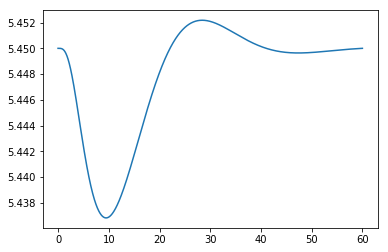

In [9]:
if __name__ == '__main__':
    # Params:
    
    Circ_0 = 5.45
    MTT = 135
    gamma = 0.174
    slope = 0.126

    n = 3
    k_tr = (n+1)/MTT
    k_prol = k_tr
    k_circ = k_tr
    dose = 2
    
    PK_params = np.load('simulated_parameters_actual_dose'+str(dose)+'.npy')
    print("PK Parameters:",PK_params)
    PD_params = [k_tr, k_prol, k_circ, Circ_0, gamma, slope]
    print("PD Parameters:",PD_params)


    times = np.linspace(-0.1,1440,1441)
    print(times)
    y_0 = [Circ_0]*5
    results = integrate.odeint(PD, y_0, times, args=(PD_params, PK_params, 2, dose))
    plt.plot(times/24, results[:, 4])
    plt.show